In [2]:
import seisbench.data as sbd
import seisbench.generate as sbg
from seisLM.model import pretrained_models
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import torch
import einops
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from seisLM.utils import project_path



ImportError: cannot import name 'pretrained_models' from 'seisLM.model' (unknown location)

In [5]:
from seisLM.utils import project_path
# from path import Path

project_path.MODEL_SAVE_DIR



'/scicore/home/dokman0000/liu0003/projects/seisLM/results/models'

In [2]:
# model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-10-22h-22m-38s/checkpoints/epoch=6-step=978355.ckpt'
# model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-16-16h-25m-15s_model_config_4xdownsample_sinkhorn/checkpoints/epoch=6-step=244587.ckpt'

# model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-06-19h-23m-17s/checkpoints/epoch=18-step=663879.ckpt'

model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-17-07h-24m-11s_model_config_4xdownsample_sinkhorn/checkpoints/epoch=4-step=87350.ckpt'
# model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-17-07h-24m-09s_model_config_4xdownsample/checkpoints/epoch=4-step=87350.ckpt'

model = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
    model_name_or_path
)
model.eval();

In [3]:
dataset = sbd.ETHZ(
  sampling_rate=100,
  component_order="ZNE",
  dimension_order="NCW",
  cache="full"
)

eval_set = 'dev'
split = dataset.get_split(eval_set)
split.preload_waveforms(pbar=True)

# task = '1'
task = '23'

task_csv = f'/scicore/home/dokman0000/liu0003/projects/seisLM/data/targets/ethz/task{task}.csv'
task_targets = pd.read_csv(task_csv)
task_targets = task_targets[task_targets["trace_split"] == eval_set]
print(len(task_targets))


if task == '1':
  task_labels = task_targets['trace_type'].to_list()
  colors = ['#1f77b4' if a == 'noise' else '#ff7f0e' for a in task_labels]
else:
  task_labels = task_targets['phase_label'].to_list()
  colors = ['#1f77b4' if a == 'P' else '#ff7f0e' for a in task_labels]


2024-06-17 17:39:06,032 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
Preloading waveforms: 100%|██████████| 3632/3632 [00:22<00:00, 162.63it/s]

5309


In [4]:
generator = sbg.SteeredGenerator(split, task_targets)
generator.add_augmentations(
  [
        sbg.SteeredWindow(windowlen=3001, strategy="pad"),
        sbg.ChangeDtype(np.float32),
        sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    ]
)

batchsize = 8
num_workers = 4
loader = DataLoader(
    generator, batch_size=batchsize, shuffle=False, num_workers=num_workers
)

In [ ]:
batch_embeddings = []

for batch in loader:
  with torch.no_grad():
    batch_embeddings.append(
      model.model(
        input_values = batch["X"].cuda()).projected_states.mean(axis=1)
    )

all_embeddings = torch.concatenate(batch_embeddings, axis=0).cpu().numpy()

hidden_states tensor([[[ 11.2290,  -7.0621,   4.1130,  ...,   1.4673,  -9.2491, -15.3697],
         [  3.9992,  -1.2677, -26.4664,  ...,  -8.6061,   1.8849,  -6.4065]],

        [[  6.6263,  -3.5767,  11.8218,  ...,   3.6444, -14.9949, -11.8400],
         [  4.1832,  -3.6356, -28.5572,  ...,  -3.0115,  -0.9926,  -8.1722]],

        [[  8.2734,  -1.3258,   9.6111,  ...,   5.8889, -11.9710, -11.1390],
         [  2.3172,  -0.2771, -29.2876,  ...,  -6.0597,   6.1284,  -9.2124]],

        ...,

        [[ -6.5464, -16.9535, -16.4187,  ..., -19.2824, -23.7790,   3.0277],
         [  4.7350, -14.3227,   5.2002,  ...,  -1.2607,  -2.9320,  13.5351]],

        [[  0.4211,  -3.4614, -16.0364,  ..., -32.4216,  -8.5001,  -6.7438],
         [ 16.2664,   0.2364,   6.4483,  ...,  10.8912, -18.5693,  18.8541]],

        [[  3.6900,  -3.6294, -23.2691,  ..., -41.2935,  -2.2285,  -4.3254],
         [ -5.1172,   6.1721,   6.1208,  ...,   4.0077, -15.5351,  18.0983]]],
       device='cuda:0')
codevector_p

KeyboardInterrupt: 

In [ ]:
from seisLM.utils.project_path import FIGURE_DIR

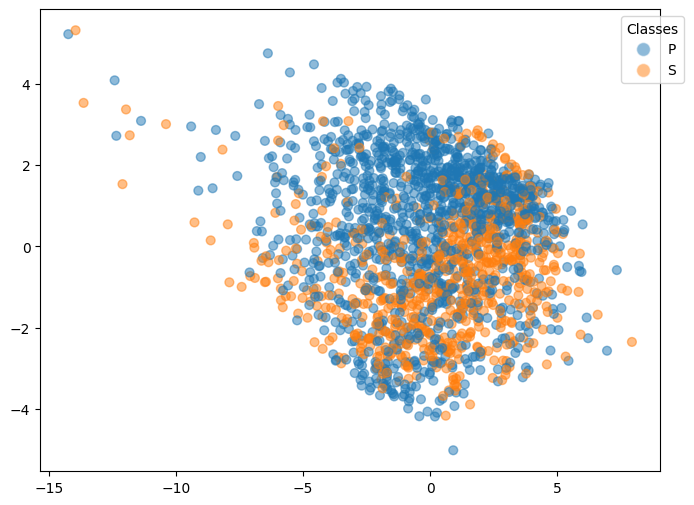

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111,)

num_points_to_show = 2000
X_reduced = PCA(n_components=2).fit_transform(all_embeddings)

scatter = ax.scatter(
    X_reduced[:, 0][:num_points_to_show],
    X_reduced[:, 1][:num_points_to_show],
    c=colors[:num_points_to_show],
    s=40,
    alpha=0.5,
    label=colors[:num_points_to_show],
)

# Create custom legend
unique_colors = np.unique(colors[:num_points_to_show])
unique_labels = np.unique(task_labels[:num_points_to_show])
handles = [plt.Line2D(
  [0], [0],
  marker='o',
  color='w',
  markerfacecolor=f'{i}', markersize=10, alpha=0.5) for i in unique_colors]

labels = [f'{i}' for i in unique_labels]
ax.legend(handles, labels, title="Classes", loc='best', bbox_to_anchor=(1.05, 1))

plt.savefig(FIGURE_DIR + f'/2d_embedding_visualization_{task}.png', dpi=300)


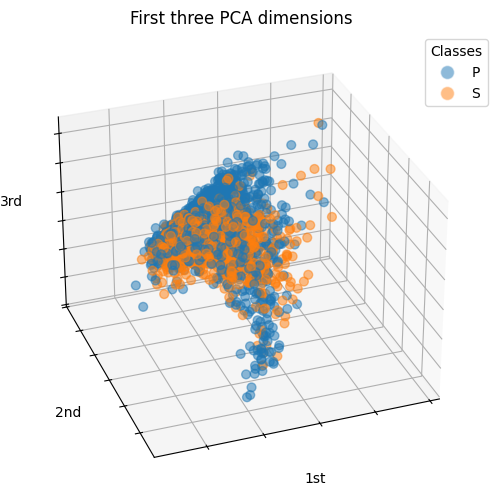

In [ ]:
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

num_points_to_show = 2000

X_reduced = PCA(n_components=3).fit_transform(all_embeddings)
ax.scatter(
    X_reduced[:, 0][:num_points_to_show],
    X_reduced[:, 1][:num_points_to_show],
    X_reduced[:, 2][:num_points_to_show],
    c=colors[:num_points_to_show],
    s=40,
    alpha=0.5,
)
# Create custom legend
unique_colors = np.unique(colors[:num_points_to_show])
unique_labels = np.unique(task_labels[:num_points_to_show])
handles = [plt.Line2D(
  [0], [0],
  marker='o',
  color='w',
  markerfacecolor=f'{i}', markersize=10, alpha=0.5) for i in unique_colors]

labels = [f'{i}' for i in unique_labels]
ax.legend(handles, labels, title="Classes", loc='best', bbox_to_anchor=(1.05, 1))


ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd")
ax.zaxis.set_ticklabels([])

# plt.show()
plt.savefig(FIGURE_DIR + f'/3d_embedding_visualization_{task}.png', dpi=300)
plt.show()